<a href="https://colab.research.google.com/github/sir-sauc3/Sugarscape-Model/blob/main/Sugarscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my take on the sugarscape model

In [1]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random
from scipy.signal import correlate2d
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
from IPython.display import clear_output


# def three_frame(world, n_seq, seed=17):
#     """Draw three timesteps.
    
#     world: object with step, loop, and draw
#     n_seq: 3-tuple, number of steps before each draw
#     seed: random see for NumPy
#     """
#     np.random.seed(seed)
#     plt.figure(figsize=(10, 4))

#     for i, n in enumerate(n_seq):
#         plt.subplot(1, 3, i+1)
#         world.loop(n)
#         world.draw()

#     plt.tight_layout()
    

# def savefig(filename, **options):
#     """Save the current figure.
#     Keyword arguments are passed along to plt.savefig
#     https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html
#     filename: string
#     """
#     print("Saving figure to file", filename)
#     plt.savefig(filename, **options)


def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.
    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d


# def decorate(**options):
#     """Decorate the current axes.
#     Call decorate with keyword arguments like
#     decorate(title='Title',
#              xlabel='x',
#              ylabel='y')
#     The keyword arguments can be any of the axis properties
#     https://matplotlib.org/api/axes_api.html
#     In addition, you can use `legend=False` to suppress the legend.
#     And you can use `loc` to indicate the location of the legend
#     (the default value is 'best')
#     """
#     loc = options.pop("loc", "best")
#     if options.pop("legend", True):
#         legend(loc=loc)

#     plt.gca().set(**options)
#     plt.tight_layout()


# def legend(**options):
#     """Draws a legend only if there is at least one labeled item.
#     options are passed to plt.legend()
#     https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
#     """
#     underride(options, loc="best", frameon=False)

#     ax = plt.gca()
#     handles, labels = ax.get_legend_handles_labels()
#     if handles:
#         ax.legend(handles, labels, **options)


# def set_palette(*args, **kwds):
#     """Set the matplotlib color cycler.
#     args, kwds: same as for sns.color_palette
#     Also takes a boolean kwd, `reverse`, to indicate
#     whether the order of the palette should be reversed.
#     returns: list of colors
#     """
#     reverse = kwds.pop('reverse', False)
#     palette = sns.color_palette(*args, **kwds)

#     palette = list(palette)
#     if reverse:
#         palette.reverse()

#     cycler = plt.cycler(color=palette)
#     plt.gca().set_prop_cycle(cycler)
#     return palette

In [3]:
DEFAULT_IMSHOW_OPTIONS = dict(
                              cmap='YlOrRd',
                              interpolation='none',
                              origin='lower',
                              vmin=0, vmax=9
                              )


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    # axes.set_title(title)
    # axes.set_xticks([], [])  # remove axes tick marks
    # axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    plt.imshow(array, **options)

In [4]:
class Cell2D:
    """Parent class for 2-D cellular automata."""

    def __init__(self, n, m=None):
        """Initializes the attributes.
        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    # def add_cells(self, row, col, *strings):
    #     """Adds cells at the given location.
    #     row: top row index
    #     col: left col index
    #     strings: list of strings of 0s and 1s
    #     """
    #     for i, s in enumerate(strings):
    #         self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    # def loop(self, iters=1):
    #     """Runs the given number of steps."""
    #     for i in range(iters):
    #         self.step()

    def draw(self, **options):
        """Draws the array.
        """
        draw_array(self.array, **options)

    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.
        
        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step
            
        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass
        

def draw_array(array):
    """Draws the cells."""

    return plot_2D_array(array, DEFAULT_IMSHOW_OPTIONS)

# def draw_array(array, **options):
#     """Draws the cells."""
#     n, m = array.shape
#     options = underride(options,
#                         cmap='Greens',
#                         alpha=0.7,
#                         vmin=0, vmax=1, 
#                         interpolation='none', 
#                         origin='upper',
#                         extent=[0, m, 0, n])

#     plt.axis([0, m, 0, n])
#     plt.xticks([])
#     plt.yticks([])

#     return plt.imshow(array, **options)

In [5]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [6]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [7]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [8]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array)#, cmap='YlOrRd', vmax=9, origin='lower'
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [9]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

In [19]:
env = Sugarscape(50, num_agents=400)

# env.draw()

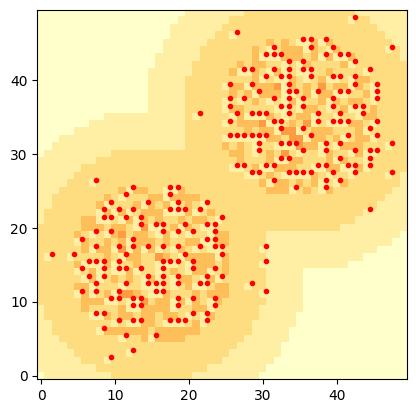

In [20]:
env.animate(frames=50)

In [12]:
len(env.agents)

253

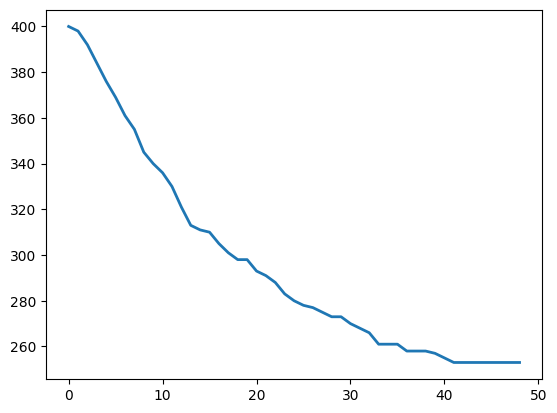

In [13]:
plt.plot(env.agent_count_seq)
# decorate(xlabel='Time steps', ylabel='Number of Agents')